In [1]:
#| default_exp mplots

# Mplots

This notebook is used for implementing basic dataclasses and functions for better integration of Matrix Profile and MPlots into deepVATS as an efficient tool for discovering boths patterns and anomalies in Large Time Series. 

This tool is introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)


## Libraries

In [2]:
#| export
## -- Deepvats
import dvats.load as load
import dvats.memory as mem
import dvats.utils as ut

## -- Matrix profile
import pyscamp as scamp
import stumpy as stump 
## -- Utilities
import os
import numpy as np
import pandas as pd
import datetime as dt
import math

## -- Classes & types
from dataclasses import dataclass, field
from typing import List
## -- Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import ImageGrid
from copy import deepcopy
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')


## Mplots functions

In [3]:
#| export
@dataclass
class MatrixProfile:
    """ Class for better usability of Matrix Profile inside deepVATS"""
    #---- Main information of the matrix profile ----#
    #-- Matrix Profile (distance array)
    matrix_profile: List[float] =  field(default_factory=list)

    # Execution information
    computation_time: float = 0.0
    
    #-- Size used for the MP computation
    subsequence_len: int = 0
    #-- Wether if stumpy or SCAMP or other method have been used 
    method: str = ''
    
    #-- Looking for motifs & neighbors
    # Ordered array for finding motifs/anomalies
    index : List[int] =  field(default_factory=list)
    # Nearest neighbours in the past (if computed)
    index_left : List[int] =  field(default_factory=list)
    # Nearest neighbours in the future (if computed)
    index_right: List[int] = field(default_factory=list)

    #--- Save the main motif index and its neighbors' index    
    motif_idx: int = 0
    motif_nearest_neighbor_idx: int = 0
    motif_nearest_neighbor_idx_left: int = 0
    motif_nearest_neighbor_idx_right: int = 0

    #--- Save the main anomaly index and its neighbors' index
    discord_idx: int = 0
    discord_nearest_neighbor_idx: int = 0
    discord_nearest_neighbor_idx_left: int = 0
    discord_nearest_neighbor_idx_right: int = 0
    
    def __str__(self):
        return f"MP: {self.matrix_profile}\nIds: {self.index}\nIds_left: {self.index_left}\nIds_right: {self.index_right}\nComputation_time: {self.computation_time}\nsubsequence_len: {self.subsequence_len}\nmethod: {self.method}"

In [4]:
#| hide
foo = MatrixProfile()
print(foo)

MP: []
Ids: []
Ids_left: []
Ids_right: []
Computation_time: 0.0
subsequence_len: 0
method: 


In [5]:
#| export
def matrix_profile(
    data, 
    subsequence_len, 
    data_b     = None,
    method     = 'scamp', 
    threads    = 4, # For scamp abjoin
    gpus       = [], # For scamp abjoin
    print_flag = False, 
    debug      = True, 
    timed      = True
):
    """ 
    This function 
    Receives
    - data: a 1D-array representing a time series values (expected to be long)
    - subsequence_len: Matrix Profile subsequences length
    - method: wether to use stump or scamp algorithm
    - print_flag: for printing or not messages
    - debug: for adding some comprobations on GPUs usability
    - timed: for getting or not the execution time for the implementation analysis
    - Threads: number of threads for scamp multithread execution
    - GPUs: id of the GPUs to be used for scamp execution

    and returns 
    - mp: matrix profile
    - index: patterns indices
    - index_left: nearest neighbors in the past
    - index_right: nearest neigbhbors in the future
    """
    
    if print_flag: print("--> matrix profile")
    #Execution time
    duration = 0.0
    # Matrix Profile (distances)
    mp = []
    # Patterns indices (position within the MP)
    index = []
    index_left = []
    index_right = []
    
    #-- Start timing
    if timed: 
        timer = ut.Time()
        timer.start()

    #-- Select the method
    match method:
        case 'stump': # Not tested
            #-- use stumpy.gpu_stump
            if print_flag: print("--> Stump (CPU)")
            mp = stump.stump(data, subsequence_len, data_b)
            #-- Save in separated columns for compatibility with SCAMP
            index = mp[:,1]
            index_left = mp[:,2]
            index_right = mp[:,3]
            mp = mp[:,0]
        
        case 'stump_gpu': # You are suposed to use this or scamp
            if print_flag: print("--> Stump (GPU)")
            #-- Matrix profile
            mp = stump.gpu_stump(data, subsequence_len, data_b)
            #-- Save in separate columns
            index = mp[:,1]
            index_left = mp[:,2]
            index_right = mp[:,3]
            mp = mp[:,0]
            
        case 'scamp': # Yo should use GPU in Large TS
            if print_flag: print("--> Scamp")
            if debug: 
                print("Check gpu use")
                has_gpu_support = scamp.gpu_supported()
                print(has_gpu_support)
            #-- Matrix profile & index. Nothing more to save
            if (data_b is None):
                mp, index = scamp.selfjoin(data, subsequence_len)
            else: 
                if print_flag: print("--> data_b provided => Executing abjoin")
                mp, index = scamp.abjoin(data, data_b, subsequence_len, threads, gpus)
        case _: #default scamp
            if print_flag: print("--> Invalid method. Using scamp [default]")
            if debug: 
                has_gpu_support = scamp.gpu_supported()
                print(has_gpu_support)
            if data_b is None:
                mp, index = scamp.selfjoin(data, subsequence_len)
            else:
                if print_flag: print("--> data_b provided => Executing abjoin")
                mp, index = scamp.abjoin(data, data_b, subsequence_len, threads, gpus)
    if timed: 
        timer.end()
        duration = timer.duration() 
    if print_flag: 
        if timed: 
            print(f"matrix profile {duration} seconds -->")
        else: 
            print("matrix profile -->")
    return mp, index, index_left, index_right, duration

In [6]:
#| hide 
foo_ts = np.random.rand(10000)
foo_m = 50
print("Ts ~", foo_ts.shape)
print("Expected mp length: ", int(np.floor(foo_ts.shape[0]-foo_m+1)))

Ts ~ (10000,)
Expected mp length:  9951


In [7]:
#| export
def compute(
    self : MatrixProfile, 
    data : List[float],
    subsequence_len : int, 
    data_b : List[float] = None,
    method : str = 'scamp',  
    threads : int = 1,
    gpus : List[int] = [],
    print_flag : bool = False, 
    debug : bool = False, 
    timed :bool = True
):
    if print_flag: print("Subsequence len: ", subsequence_len)
    self.subsequence_len = subsequence_len
    self.method = method
    self.matrix_profile, self.index, self.index_left, self.index_right, self.computation_time = matrix_profile(
        data, subsequence_len, data_b, method, threads, gpus, print_flag, debug, timed
    )
    return self.matrix_profile
MatrixProfile.compute = compute

In [8]:
foo_mp = MatrixProfile()
print(foo_ts)
print(foo_m)

[0.3818046  0.44689723 0.22015676 ... 0.91734912 0.98336753 0.24261369]
50


In [9]:
#| hide
foo_mp.compute(
    data = foo_ts, 
    subsequence_len = foo_m, 
    method = 'scamp', 
    print_flag = True,
    debug = True,
    timed = True
)
print(foo_mp)

Subsequence len:  50
--> matrix profile
--> Scamp
Check gpu use
True
matrix profile 0.3196690082550049 seconds -->
MP: [6.907617  6.9377055 6.881147  ... 6.466331  6.764476  7.0313153]
Ids: [3370 3371 3372 ... 3018 3019 3020]
Ids_left: []
Ids_right: []
Computation_time: 0.3196690082550049
subsequence_len: 50
method: scamp


In [11]:
#| hide
foo_mp.compute(
    data            = foo_ts, 
    subsequence_len = foo_m, 
    method          = 'stump', 
    print_flag      = True, 
    debug           = True, 
    timed           = True
)

Subsequence len:  50
--> matrix profile
--> Stump (CPU)
matrix profile 18.057798624038696 seconds -->


array([6.907617129521356, 6.93770574102448, 6.8811466266341785, ...,
       6.466331388539139, 6.764475679466241, 7.0313153879893155],
      dtype=object)

In [13]:
#| hide
#| hide
foo_mp.compute(
    data            = foo_ts, 
    subsequence_len = foo_m, 
    method          = 'escampo', 
    print_flag      = True, 
    debug           = True, 
    timed           = True
)

Subsequence len:  50
--> matrix profile
--> Invalid method. Using scamp [default]
True
matrix profile 0.16711664199829102 seconds -->


array([6.907617 , 6.9377055, 6.881147 , ..., 6.466331 , 6.764476 ,
       7.0313153], dtype=float32)

In [27]:
#| export
@dataclass
class MatrixProfiles:
    matrix_profiles: List[MatrixProfile] =  field(default_factory=list)
    data: List[float] = field(default_factory=list)
    data_b : List[float] = None
    
    subsequence_len: int = 0

    def append(self, mp: MatrixProfile):
        self.matrix_profiles.append(deepcopy(mp))
        self.subsequence_len = mp.subsequence_len
    def compute(
        self, 
        method : str      = 'scamp',  
        threads: int      = 1,
        gpus : List[int]  = field(default_factory=list),
        print_flag : bool = False, 
        debug : bool      = False, 
        timed : bool      = True
    ):
        """ 
        Computes the Matrix Profile for data & data_b arrays using subsequence_len length.
        Appends the resulting MP to the matrix_profiles list.
        """
        mp = MatrixProfile()
        mp.compute(
            data            = self.data, 
            subsequence_len = self.subsequence_len, 
            data_b          = self.data_b,
            method          = method, 
            threads         = threads,
            gpus            = gpus,
            print_flag      = print_flag, 
            debug           = debug, 
            timed           = timed
        )
        
        mp.method = method
        self.matrix_profiles.append(mp)
        
        if print_flag: 
            print("MPs | compute -> Subsequence len outside: ", self.subsequence_len)
            print("MPs | compute -> Subsequence len inside: ", mp.subsequence_len)
            print("MPs | compute -> method outside: ", self.matrix_profiles[-1].method)
            print("MPs | compute -> method inside: ", mp.method)
        return mp
    
    def plot(self, ids = []):
        if ids == []: ids = range(len(self.matrix_profiles))
        num_plots = len(ids)+1
        fig = plt.figure(figsize=(10, 6))
        gs = GridSpec(num_plots, 1, height_ratios=[1] + [4] * (num_plots -1))
        # Serie temporal
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(self.data, label="Data")
        ax1.set_title("Time Serie")
        ax1.legend()
        # MPlots
        for i in ids:
            ax2 = fig.add_subplot(gs[i+1], sharex=ax1)
            mp_values = self.matrix_profiles[i].matrix_profile.astype(float)
            ax2.imshow(mp_values.reshape(-1, 1).T, aspect='auto', origin='lower', cmap='hot', extent=(0, len(self.data), 0, self.subsequence_len))
            ax2.set_title(f"MPlot - {i} - {self.matrix_profiles[i].method}")
        plt.tight_layout()
        plt.show()

    def get_ordered_idx(self, id, pos):
        mp_sorted = np.argsort( self.matrix_profiles[id].matrix_profile )
        return mp_sorted[pos]
        
    def get_motif_idx(self, id): 
        motif_idx = self.get_ordered_idx(id, 0)
        self.matrix_profiles[id].motif_idx = motif_idx
        self.matrix_profiles[id].motif_nearest_neighbor_idx = self.matrix_profiles[id].index[motif_idx]
        
        if ( self.matrix_profiles[id].method == 'stump' ):
            self.matrix_profiles[id].motif_nearest_neighbor_idx_left = self.matrix_profiles[id].index_left[motif_idx]
            self.matrix_profiles[id].motif_nearest_neighbor_idx_right = self.matrix_profiles[id].index_right[motif_idx]
        return self.matrix_profiles[id].motif_idx, self.matrix_profiles[id].motif_nearest_neighbor_idx, self.matrix_profiles[id].motif_nearest_neighbor_idx_left, self.matrix_profiles[id].motif_nearest_neighbor_idx_right
    
    def get_anomaly_idx(self, id): 
        discord_idx = self.get_ordered_idx(id, -1)
        self.matrix_profiles[id].discord_idx = discord_idx
        self.matrix_profiles[id].discord_nearest_neighbor_idx = self.matrix_profiles[id].index[discord_idx]
        
        if ( self.matrix_profiles[id].method == 'stump' ):
            self.matrix_profiles[id].discord_nearest_neighbor_idx_left = self.matrix_profiles[id].index_left[discord_idx]
            self.matrix_profiles[id].discord_nearest_neighbor_idx_right = self.matrix_profiles[id].index_right[discord_idx]
            
        return self.matrix_profiles[id].discord_idx, self.matrix_profiles[id].discord_nearest_neighbor_idx, self.matrix_profiles[id].discord_nearest_neighbor_idx_left, self.matrix_profiles[id].discord_nearest_neighbor_idx_right
    
    
    def plot_motif(
        self, 
        ts_name,
        id, 
        idx, 
        nearest_neighbor_idx, 
        title_fontsize = '30', 
        other_fontsize = '20'
    ): 
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.4})
        plt.suptitle('Motif (Pattern) Discovery | ' + self.matrix_profiles[id].method , fontsize=title_fontsize)

        axs[0].plot(self.data.values)
        axs[0].set_ylabel(ts_name, fontsize=other_fontsize)
        rect = Rectangle((idx, 0), self.subsequence_len, 40, facecolor='lightgrey')
        axs[0].add_patch(rect)
        rect = Rectangle((nearest_neighbor_idx, 0), self.subsequence_len, 40, facecolor='lightgrey')
        axs[0].add_patch(rect)
        axs[1].set_xlabel('Index', fontsize =other_fontsize)
        axs[1].set_ylabel('Matrix Profile', fontsize=other_fontsize)
        axs[1].axvline(x=idx, linestyle="dashed", color = "black")
        axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed", color="red")
        axs[1].plot(self.matrix_profiles[id].matrix_profile)
        plt.show()
        
        


In [16]:
#| hide
foo_mps = MatrixProfiles()
foo_mps.data = foo_ts
foo_mps.subsequence_len = 50
print("Ts ~ ", foo_mps.data.shape)
print("Expected mp length: ", int(np.floor(foo_mps.data.shape[0]-foo_mps.subsequence_len+1)))
foo_mps.compute('stump_gpu',  True, True, True)
print("Total MPs: ", len(foo_mps.matrix_profiles))
print(foo_mps.matrix_profiles[0])
foo_mps.compute('scamp',  True, True, True)
print("Total MPs: ", len(foo_mps.matrix_profiles))
print(foo_mps.matrix_profiles[1])

Ts ~  (10000,)
Expected mp length:  9951
Subsequence len:  50
--> matrix profile
--> Stump (GPU)


/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


matrix profile 2.9824020862579346 seconds -->
MPs | compute -> Subsequence len out:  50
MPs | compute -> Subsequence len inside:  50
Total MPs:  1
MP: [6.907617129521366 6.937705741024487 6.881146626634184 ...
 6.466331388539131 6.764475679466244 7.031315387989313]
Ids: [3370 3371 3372 ... 3018 3019 3020]
Ids_left: [-1 -1 -1 ... 3018 3019 3020]
Ids_right: [3370 3371 3372 ... -1 -1 -1]
Computation_time: 2.9824020862579346
subsequence_len: 50
method: stump_gpu
Subsequence len:  50
--> matrix profile
--> Scamp
matrix profile 0.10065746307373047 seconds -->
MPs | compute -> Subsequence len out:  50
MPs | compute -> Subsequence len inside:  50
Total MPs:  2
MP: [6.907617  6.9377055 6.881147  ... 6.466331  6.764476  7.0313153]
Ids: [3370 3371 3372 ... 3018 3019 3020]
Ids_left: []
Ids_right: []
Computation_time: 0.10065746307373047
subsequence_len: 50
method: scamp


In [17]:
#| hide
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()
steam_mps = MatrixProfiles()
steam_mps.subsequence_len = 640
steam_mps.data = steam_df['steam flow']
steam_mps.compute('scamp', print_flag = True, debug = False, timed = True)
steam_mps.compute('stump', print_flag = True, debug = False, timed = True)
print(foo_mps.get_motif_idx(0))
print(foo_mps.get_motif_idx(1))

Subsequence len:  640
--> matrix profile
--> Scamp
matrix profile 0.11546897888183594 seconds -->
MPs | compute -> Subsequence len out:  640
MPs | compute -> Subsequence len inside:  640
Subsequence len:  640
--> matrix profile
--> Stump (CPU)
matrix profile 0.5423107147216797 seconds -->
MPs | compute -> Subsequence len out:  640
MPs | compute -> Subsequence len inside:  640
(5522, 2193, 0, 0)
(2193, 5522, 0, 0)


In [18]:
#| hide

print("---- Motifs 0 ----")
steam_mps.get_motif_idx(1)
print("idx",  steam_mps.matrix_profiles[1].motif_idx)
print("nn", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx)
print("left", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx_left)
print("right", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx_right)

print("---- Motifs 1 ----")
steam_mps.get_motif_idx(1)
print("idx", steam_mps.matrix_profiles[1].motif_idx)
print("nn", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx)
print("left", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx_left)
print("right", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx_right)


print("---- Anomalies 0 ----")
steam_mps.get_anomaly_idx(0)
print("idx", steam_mps.matrix_profiles[0].discord_idx)
print("nn", steam_mps.matrix_profiles[0].discord_nearest_neighbor_idx)
print("left", steam_mps.matrix_profiles[0].discord_nearest_neighbor_idx_left)
print("right", steam_mps.matrix_profiles[0].discord_nearest_neighbor_idx_right)


print("---- Anomalies 1 ----")
steam_mps.get_anomaly_idx(1)
print("idx", steam_mps.matrix_profiles[1].discord_idx)
print("nn", steam_mps.matrix_profiles[1].discord_nearest_neighbor_idx)
print("left", steam_mps.matrix_profiles[1].discord_nearest_neighbor_idx_left)
print("right", steam_mps.matrix_profiles[1].discord_nearest_neighbor_idx_right)

---- Motifs 0 ----
idx 643
nn 8724
left 296
right 8724
---- Motifs 1 ----
idx 643
nn 8724
left 296
right 8724
---- Anomalies 0 ----
idx 3864
nn 4755
left 0
right 0
---- Anomalies 1 ----
idx 3864
nn 4755
left 1864
right 4755


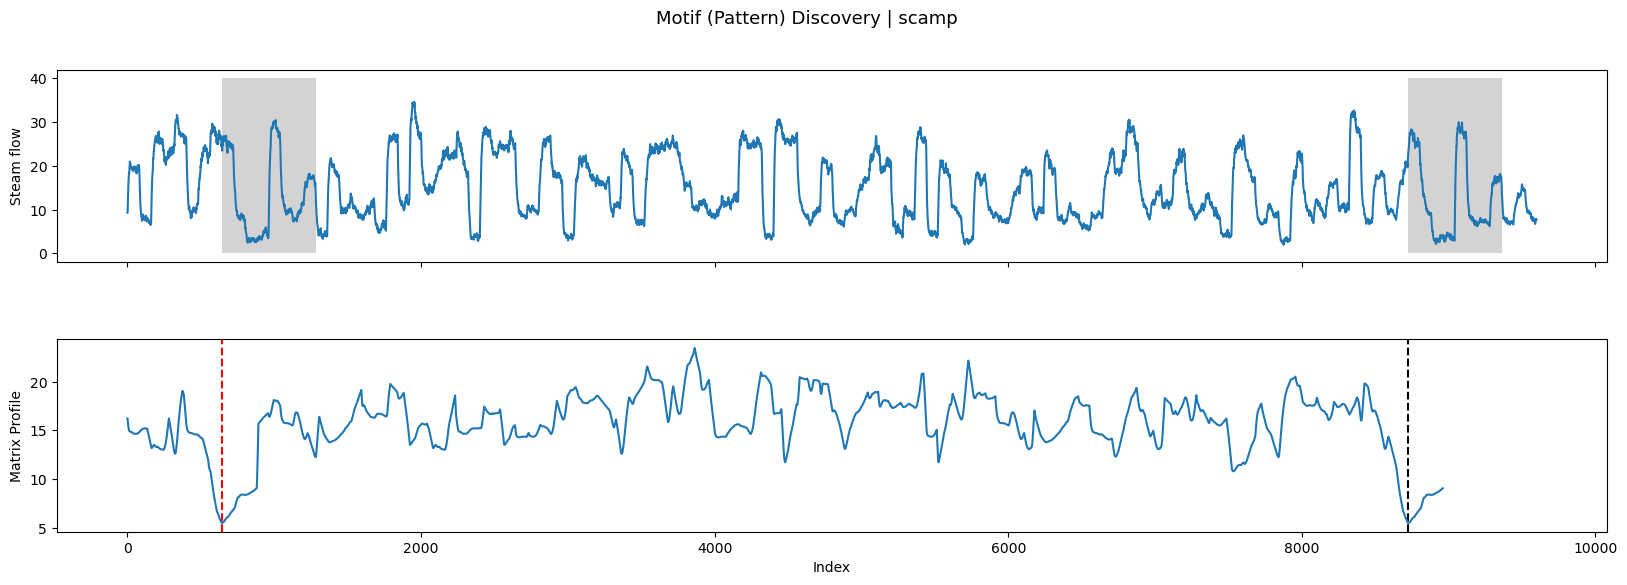

In [20]:
#| hide
stumpy_idxs = steam_mps.get_motif_idx(0)
steam_mps.plot_motif(
    ts_name = 'Steam flow', 
    id = 0, 
    idx = stumpy_idxs[0], 
    nearest_neighbor_idx = stumpy_idxs[1], 
    title_fontsize = '13', 
    other_fontsize = '10'
)

In [28]:
#| hide
foo_mps = MatrixProfiles()

In [31]:
#| hide
## -- setup foo_mps
foo_mps.data = foo_ts
foo_mps.sequence_len = foo_m

## -- Compute a MP
foo_mp.compute(
    data            = foo_ts, 
    subsequence_len = foo_m, 
    method          = 'scamp', 
    print_flag      = False, 
    debug           = False,
    timed           = True
)

## -- Append MP
foo_mps.append(foo_mp)
print("foo_mp.method: ", foo_mp.method)
print("First foo_mps method: ", foo_mps.matrix_profiles[0].method)

## -- Compute another MP
foo_mps.compute(
    method           = 'stump_gpu', 
    print_flag       = False, 
    debug            = False,
    timed            = True
)


print("foo_mps 0: ", foo_mps.matrix_profiles[0].method)
print("foo_mps 1: ", foo_mps.matrix_profiles[1].method)

foo_mp.method:  scamp
First foo_mps method:  scamp
foo_mps 0:  scamp
foo_mps 1:  stump_gpu


In [36]:
#| hide 
print("0 - scamp:", foo_mps.matrix_profiles[0].computation_time)
print("1 - stumpy:", foo_mps.matrix_profiles[1].computation_time)

0 - scamp: 0.130265474319458
1 - stumpy: 2.9325129985809326


In [ ]:
#| hide
foo_mps.plot([])

In [37]:
#| hide 
print(foo_mps.matrix_profiles[0].computation_time)
print(foo_mps.matrix_profiles[1].computation_time)

0.130265474319458
2.9325129985809326


## Plotting auxiliar functions

In [38]:
#| export
def plot_dataFrame(title, df, vars = [], interval = 10000):
    if len(vars) > 0:
        num_vars = len(df.columns)
    
        for var_num in vars:
            if var_num >= len(df.columns):
                raise ValueError("var_num "+var[var_num] + "is out of the range of DataFrame columns: " + num_vars)

        num_vars = len(vars)
        
        ### Start the plot 

        #fig = plt.figure(figsize=(10, num_intervals * 3))  # Ajusta el tamaño del plot según el número de intervalos
        
        num_intervals = df.shape[0] // interval + 1
        fig = plt.figure(figsize=(10, num_vars * num_intervals * 3))  ## Size
        gs = GridSpec(num_intervals*num_vars, 1) # 1 column, len(vars) rows
        var_pos = 0
        for var_num  in vars:
            var_name = df.columns[var_num]
            data = df[var_name]
            for i in range(num_intervals):    
                start_idx = i * interval
                end_idx = len(data) if i == (num_intervals - 1) else start_idx + interval
                ax = fig.add_subplot(gs[var_pos+i])
                ax.plot(np.arange(start_idx, end_idx), data[start_idx:end_idx], label=f"{var_name} [{start_idx}, {end_idx}]")
                ax.set_title(f"{var_name} [{start_idx}, {end_idx}]")
                ax.set_xlabel("Time")
                ax.set_ylabel(var_name)
                ax.legend()
            var_pos += 1
                
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()
    else: raise ValueError("No variable proposed for plotting")

In [39]:
#| export 
def plot_dataFrame_compareSubsequences(
    title, df, var, subsequence_len, seq1_init, seq2_init, 
    title_fontsize = '30',
    others_fontsize='20'
):
    fig, axs = plt.subplots(2)
    fig.subplots_adjust(hspace=0.4) 
    plt.suptitle(title, fontsize=title_fontsize)
    var_name = df.columns[var]
    axs[0].set_ylabel(var_name, fontsize=others_fontsize)
    axs[0].plot(df[var_name], alpha=0.5, linewidth=1)
    axs[0].plot(df[var_name].iloc[seq1_init:seq1_init+subsequence_len])
    axs[0].plot(df[var_name].iloc[seq2_init:seq2_init+subsequence_len])
    rect = Rectangle((seq1_init, 0), subsequence_len, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[0].set_xlabel("Index", fontsize=others_fontsize)

    rect = Rectangle((seq2_init, 0), subsequence_len, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel("Relative Index (subsequence)", fontsize=others_fontsize)
    axs[1].set_ylabel(var_name, fontsize=others_fontsize)
    axs[1].plot(df[var_name].values[seq1_init:seq1_init+subsequence_len], color='C1')
    axs[1].plot(df[var_name].values[seq2_init:seq2_init+subsequence_len], color='C2')
    plt.show()
    

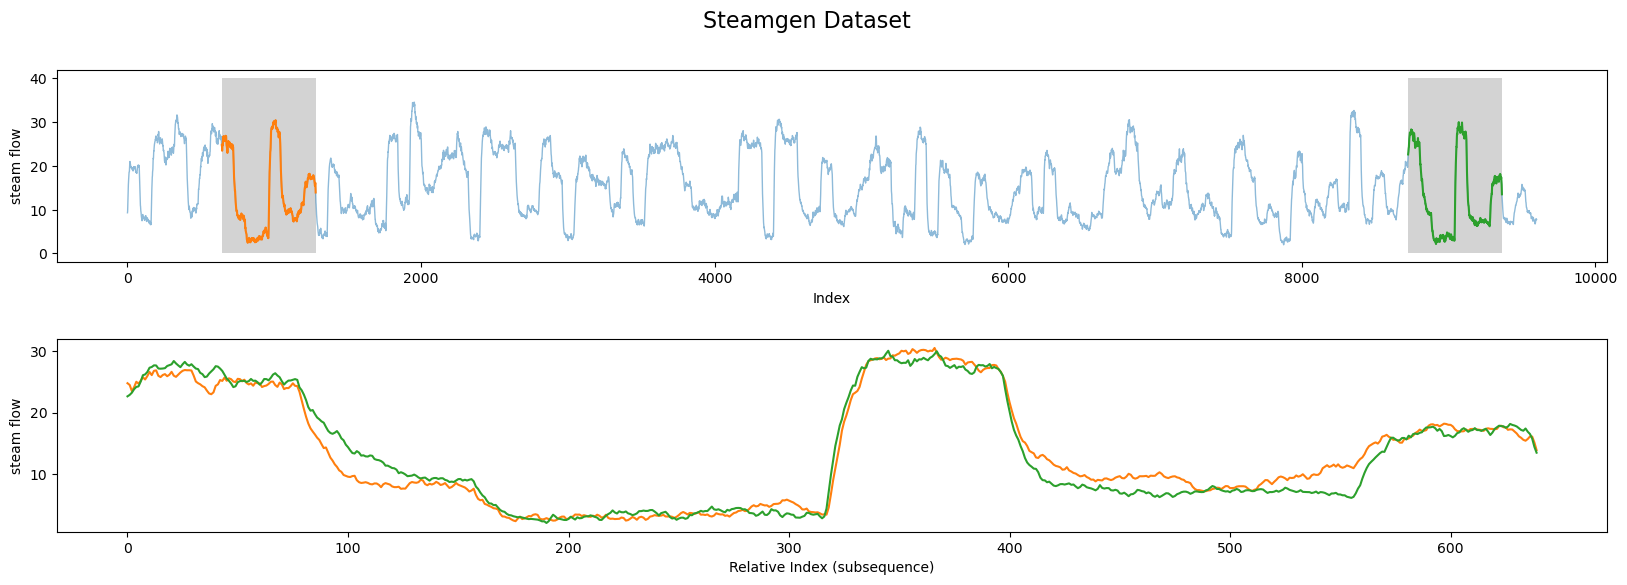

In [40]:
#| hide
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()
plot_dataFrame_compareSubsequences('Steamgen Dataset', steam_df, 3, 640, 643, 8724, '16', '10')

In [41]:
#| export
def df_plot_colored_variables(df):
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    #df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    df.plot(colormap=cmap, ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    display(plt.show())

In [42]:
#| export
def plot_df_with_intervals_and_colors(title, df, interval=10000):
    num_variables = len(df.columns)
    num_intervals = len(df) // interval + 1  # Calcula el número necesario de intervalos/subplots

    fig = plt.figure(figsize=(10, num_intervals * 3 * num_variables))  # Ajusta el tamaño del plot
    gs = GridSpec(num_intervals * num_variables, 1)
    
    cmap = matplotlib.colormaps.get_cmap('viridis')

    for var_num, var in enumerate(df.columns):
        data = df[var]
        for i in range(num_intervals):
            ax = fig.add_subplot(gs[var_num * num_intervals + i])
            start_idx = i * interval
            end_idx = start_idx + interval

            if i == num_intervals - 1:  # Ajusta el último intervalo para incluir todos los datos restantes
                end_idx = len(data)

            color = cmap(var_num / num_variables)  # Asigna un color basado en la variable
            ax.plot(np.arange(start_idx, end_idx), data[start_idx:end_idx], label=f"{var} [{start_idx}, {end_idx}]", color=color)
            ax.set_title(f"{var} [{start_idx}, {end_idx}]")
            ax.set_xlabel("Index")
            ax.set_ylabel(var)
            ax.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [43]:
#| export
def plot_motif(df, motif_idx, nearest_neighbor_idx, variable_name, title, padding = 1000, m = 1, mp = None):
    fig, axs = plt.subplots(2, sharex = True, gridspec_kw={'hspace': 0})
    plt.suptitle('Motif (Pattern) Discovery', fontsize='30')
    padding = min(padding, len(df[variable_name].values) // 2)

    # Calcula los límites para hacer zoom
    x_min = max(min(motif_idx, nearest_neighbor_idx) - padding, 0)
    x_max = min(max(motif_idx, nearest_neighbor_idx) + padding, len(df[variable_name].values))

    axs[0].plot(df[variable_name].values)
    axs[0].set_xlim([x_min, x_max])  # Aplica el zoom aquí
    axs[0].set_ylabel(title, fontsize='20')
        
    axs[0].set_ylabel(title, fontsize='20')
    rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='20')
    axs[1].set_ylabel('Matrix Profile', fontsize='20')
    axs[1].axvline(x=motif_idx, linestyle="dashed")
    axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
    axs[1].plot(mp)
    plt.show()

In [44]:
#| export
def plot_motif_separated(df, motif_idx=0, nearest_neighbor_idx=0, variable_name="", title="", padding=1000, m=1, mp=None):
    fig, axs = plt.subplots(4, sharex=False, figsize=( 12, 5), gridspec_kw={'hspace': 0.5})
    plt.suptitle('Motif (Pattern) Discovery', fontsize='20')
    
    padding = max(m, min(padding, len(df[variable_name].values) // 2))

    x_min_motif = max(motif_idx - padding, 0)
    x_max_motif = min(motif_idx + padding, len(df[variable_name].values))

    axs[0].plot(df[variable_name].values)
    axs[0].set_xlim([x_min_motif, x_max_motif])
    axs[0].set_ylabel(title, fontsize='10')
    rect_motif = Rectangle((motif_idx, df[variable_name].min()), m, df[variable_name].max() - df[variable_name].min(), facecolor='lightgrey')
    axs[0].add_patch(rect_motif)

    axs[1].plot(mp)
    axs[1].set_xlim([x_min_motif, x_max_motif])
    axs[1].set_xlabel('Time', fontsize='10')
    axs[1].set_ylabel('MP - Min', fontsize='10')
    axs[1].axvline(x=motif_idx, linestyle="dashed")

    x_min_neighbor = max(nearest_neighbor_idx - padding, 0)
    x_max_neighbor = min(nearest_neighbor_idx + padding, len(df[variable_name].values))

    axs[2].plot(df[variable_name].values)
    axs[2].set_xlim([x_min_neighbor, x_max_neighbor])
    axs[2].set_ylabel(title, fontsize='10')
    rect_neighbor = Rectangle((nearest_neighbor_idx, df[variable_name].min()), m, df[variable_name].max() - df[variable_name].min(), facecolor='lightgrey')
    axs[2].add_patch(rect_neighbor)

    axs[3].plot(mp)
    axs[3].set_xlim([x_min_neighbor, x_max_neighbor])
    axs[3].set_xlabel('Time', fontsize='10')
    axs[3].set_ylabel('MP-max', fontsize='10')
    axs[3].axvline(x=nearest_neighbor_idx, linestyle="dashed")

    plt.show()

## Download & load matrices
> Eamonn uses to save public examples data in Google Drive as matlab matrices
> 
> This part of the code is for directly downloading such data from the jupyter notebook 

In [45]:
#| export
class GD_Mat:
    def __init__(self, id,  name, data_path = '~/data'):
        self.id                 = id #GD id
        self.data_path          = os.path.expanduser(data_path) # Local data path
        self.zip_path           = os.path.join(self.data_path, name + '.zip')
        self.mat_path           = os.path.join(self.data_path, name + '.mat')
        self.mats_files         = None
        self.mats               = None #Downloaded matlab matrices
        self.mats_df            = None
        self.num_mats           = 0
        self.num_mats_extracted = 0
        
    def download_file_from_google_drive(self):
        return load.download_file_from_google_drive(self.id, self.zip_path)
        
    def get_mat_files(self):
        self.mats_files = [f for f in load.zip_contents(self.zip_path) if not f.startswith('__MACOSX/')]
        self.num_mats = len(self.mats_files)
        self.mats = self.mats_df = [None]*self.num_mats
    
    def unzip_mat(self, all_one, case = '', print_flag = False): 
        str = load.unzip_mat(all_one, self.zip_path, self.data_path, case, print_flag)
        self.get_mat_files()
        return str
        
    def mat2csv(self, case_id, print_flag = False):
        if print_flag: print("--> mat2csv", case_id)
        case = self.mats_files[case_id]
        case_path = os.path.join(self.data_path, case)
        print("Mat2csv case", case_path)
        self.mats_df[case_id] = load.mat2csv(case_path, self.data_path, print_flag)
        if print_flag: print("mat2csv", case_id, "-->")
        
    def __str__(self): 
        str = f"FileID: {self.id}\nData path: {self.data_path}\n"
        str += f"zip path: {self.zip_path}\nmat_files: {self.mats_files}"
        str +=f"\nnum_mats: {self.num_mats}"
        return str
    

In [46]:
#| hide 
file_id = '1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ'
name = 'InsectData-fig11'

gd_mat = GD_Mat(file_id, name)
print(gd_mat)
gd_mat.unzip_mat('all')
print(gd_mat)
gd_mat.mat2csv(0)
print(gd_mat)
display(gd_mat.mats_df[0].head(5))

FileID: 1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ
Data path: /home/macu/data
zip path: /home/macu/data/InsectData-fig11.zip
mat_files: None
num_mats: 0
FileID: 1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ
Data path: /home/macu/data
zip path: /home/macu/data/InsectData-fig11.zip
mat_files: ['Insect_one_million.mat']
num_mats: 1
Mat2csv case /home/macu/data/Insect_one_million.mat
FileID: 1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ
Data path: /home/macu/data
zip path: /home/macu/data/InsectData-fig11.zip
mat_files: ['Insect_one_million.mat']
num_mats: 1


,Insect_one_million
0,0.236820
1,0.236820
2,0.238040
3,0.206300
4,0.026855


## Mplots
> This part is specific for the similarity matrix plots (MPlots)
> Although it is more the Distance Profile than the Matrix Profile perse, I preferred to maintain MatrixProfilePlot for memotecnic (MPlots)

TODO: Esta funcion la he copiado y pegado de [Zach - SCAMP (GitHub) ](https://github.com/zpzim/SCAMP/blob/b55f1baf31b03ffb824c22336919cecfbf40ea92/test/distance_matrix_fast.py)
Ver cómo importarla bien de SCAMP, que no lo conseguí

In [94]:
#| export 
def moving_mean(a, w):
  result = np.zeros((len(a) - w + 1,))
  p = a[0]
  s = 0
  for i in range(1, w):
    x = p + a[i]
    z = x - p
    s += (p - (x - z)) + (a[i] - z)
    p = x
  
  result[0] = (p + s) / w

  for i in range(w, len(a)):
    x = p - a[i - w]
    z = x - p
    s += (p - (x - z)) - (a[i - w] + z)
    p = x

    x = p + a[i]
    z = x - p
    s += (p - (x - z)) + (a[i] - z)
    p = x
    result[i - w + 1] = (p + s) / w

  return result;
def sum_of_squared_differences(a, means, w):
  result = np.zeros((len(a) - w + 1,))
  for i in range(len(a) - w + 1):
    vals = a[i:i+w] - means[i]
    vals = vals * vals
    result[i] = np.sum(vals)
  return result
def get_precomputes(T, m, nanvalues):
  flatness_epsilon = 1e-13
  n = len(T) - m + 1;
  df = np.zeros((n,))
  dg = np.zeros((n,))

  means = moving_mean(T,m)

  norms = sum_of_squared_differences(T, means, m)

  for i in range(n):
    if nanvalues[i]:
      norms[i] = np.nan
    elif norms[i] <= flatness_epsilon:
      norms[i] = np.nan
    else:
      norms[i] = 1.0 / math.sqrt(norms[i])

  for i in range(n-1):
    df[i] = (T[i + m] - T[i]) / 2.0;
    dg[i] = (T[i + m] - means[i + 1]) + (T[i] - means[i]);

  return means, norms, df, dg
def convert_non_finite_to_zero(T, m):
  timeseries_clean = np.zeros((len(T),))
  nanvals = np.zeros((len(T) - m + 1,))
  steps_since_last_nan = m
  for i in range(len(T)):
    if np.isfinite(T[i]):
      timeseries_clean[i] = T[i]
    else:
      steps_since_last_nan = 0
      timeseries_clean[i] = 0
    if i >= m - 1:
      nanvals[i - m + 1] = steps_since_last_nan < m
    steps_since_last_nan += 1
  return timeseries_clean, nanvals
# Computes the distance matrix using the diagonal update method used in SCAMP
def distance_matrix(a,b,w):
    has_b = True
    if b is None:
        has_b = False
        b = a
    na = len(a) - w + 1
    if not has_b:
        nb = na
    else:
        nb = len(b) - w + 1
    out = np.ones((nb,na)) * -2


    a, nan_a = convert_non_finite_to_zero(a,w)
  
    if has_b:
      b, nan_b = convert_non_finite_to_zero(b,w)
    else:
      b = a;

    mua, siga, dfa, dga = get_precomputes(a,w,nan_a)
    if not has_b:
        mub = mua
        sigb = siga
        dfb = dfa
        dgb = dga
    else:
        mub, sigb, dfb, dgb = get_precomputes(b,w, nan_b)

    diagmax = na
    if not has_b:
        minlag = w // 4
    else:
        minlag = 0

    
    c = np.zeros((diagmax - minlag,)) 
    for diag in range(minlag,diagmax):
      c[diag-minlag] = np.sum((a[diag:diag+w]-mua[diag]) * (b[:w]-mub[0]))
    
    for offset in range(nb-minlag):
      result = c*(sigb[offset]*siga[minlag+offset:])
      out[offset, minlag+offset:] = result
      if not has_b:
        out[minlag+offset:, offset] = result
      x = c + dfb[offset] * dga[minlag+offset:] + dfa[minlag+offset:]*dgb[offset]
      c = x[:-1]
    if has_b:
      diagmax = nb
      c = np.zeros((diagmax - minlag,)) 
      for diag in range(minlag,diagmax):
        c[diag-minlag] = np.sum((b[diag:diag+w]-mub[diag]) * (a[:w]-mua[0]))
      for offset in range(na-minlag):
        result = c*(siga[offset]*sigb[minlag+offset:])
        out[minlag+offset:, offset] = result
        x = c + dfa[offset] * dgb[minlag+offset:] + dfb[minlag+offset:]*dga[offset]
        c = x[:-1]

    out[np.isnan(out)] = -2;
    return out

In [131]:
#| export
def make_symmetric_(mat : np.array(float)) -> None:
    """ Ensures down-left triangle equals to up-right triangle """
    for i in range(len(mat)):
       mat[i:,i] = mat[i,i:]
def check_symmetric(mat : np.array(float)) -> bool:
    """ Check wether if down-left triangle equals to up-right triangle """
    sym = True
    i = 0
    while (i < len(mat) and sym):
        sym = np.array_equal(mat[i:,i], mat[i,i:])
        i+=1
    return sym


In [132]:
#| hide
foo = np.array([[1,2,3], [4,5,6], [7,8,9]])
print(check_symmetric(foo))
print(foo)
make_symmetric_(foo)
print(foo)
print(check_symmetric(foo))

False
[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 2 3]
 [2 5 6]
 [3 6 9]]
True


In [147]:
#| export 
@dataclass
class DistanceProfile: 
    """ Similarity matrix """
    # -- Similarity Matrix / Distance Profile
    similarity_matrix: List[ List [ float ] ] = field(default_factory=list)
    # -- Time series A (Query Time Serie
    data: List [ float ]  = None
    # -- Reference sequence
    data_b : List [ float ]  = None
    # -- 
    subsequence_len : int = 1

    def compute(
        self,
        method                      = 'scamp',
        print_flag : bool           = False,
        debug : bool                = False,
        timed : bool                = True, 
        allow_experimental : bool   = True, 
        ensure_symetric : bool    = True,
    ) -> List [ List [ float ] ] :
        complete             = self.data_b == None
        n                    = len(self.data)
        rows                 = n - self.subsequence_len + 1
        if (complete): 
            columns = rows
            reference_seq = self.data
        else: 
            reference_seq = data_b
            columns = len(reference_seq) + 1
        self.similarity_matrix = np.empty((rows, columns))
        if timed: 
            timer = ut.Time()
            timer.start()
        match method:
            case 'stump':
                if print_flag: print("--> Stump")
                for i in range(rows):
                    self.similarity_matrix[i,:] =  stump.core.mass(
                        self.data[i:i + self.subsequence_len], reference_seq
                    )
                        
            case 'scamp': 
                if print_flag: print("--> Scamp")
                if complete and allow_experimental:
                    if print_flag: 
                        print("--> selfjoin_matrix", self.similarity_matrix.shape)
                        
                        self.similarity_matrix = scamp.selfjoin_matrix(
                            self.data, 
                            self.subsequence_len,
                            gpus = [],
                            mheight = n - self.subsequence_len + 1,
                            mwidth = n - self.subsequence_len + 1,
                            verbose = print_flag,
                            pearson = True
                        )
                    if print_flag: print("selfjoin_matrix -->", self.similarity_matrix.shape)
                else:
                
                    self.similarity_matrix = distance_matrix(
                            self.data, #a_data
                            reference_seq,  #b_data
                            self.subsequence_len #windos
                        )
                        
            case _: #default scamp
                if print_flag: print("--> Invalid method. Using scamp [default]")
                self.similarity_matrix = distance_matrix(
                    self.data, #a_data
                    reference_seq,  #b_data
                    self.subsequence_len #windos
                )
                #if print_flag: print("--> Scamp")
                #self.similarity_matrix, _ = scamp.selfjoin(self.data, self.subsequence_len)
        if timed: 
            timer.end()
            duration = timer.duration() 
        if print_flag: 
            if timed: 
                print(f"matrix profile {duration} seconds -->")
            else: 
                print("matrix profile -->")
        #TODO: En mplot_explorer se asegura de que la matriz sea simétrica respecto a la diagonal
        # y tiene sentido, cuando es cuadrada, pero.... siendo así... 
        # ¿Por qué la guardo entera? Ya he guardado antes matrices simétricas como triangulares...
        # -> Pensar en cómo afectaría. Tiene sentido para el caso en que rows = columns.
        if (ensure_symetric and rows == columns) : 
            make_symmetric_(self.similarity_matrix)
        return self.similarity_matrix    
    

In [143]:
#| hide 
foo = DistanceProfile(data = steam_df['steam flow'], subsequence_len = 640)
foo

reference_idx = np.random.randint(low=0, high=len(foo_ts) - 640)
reference_subseq = foo_ts[reference_idx:reference_idx + 640]

foo.compute(
    method     = 'stump', 
    print_flag = True, 
    debug      = False,
    timed      = True,
    ensure_symetric = False
)

check_symmetric(foo.similarity_matrix)
foo.similarity_matrix
#foo.plot('Steam flow', 'Stumpy')

--> Stump
matrix profile 53.05621552467346 seconds -->


array([[5.33120150e-07, 1.74846009e+00, 3.04914479e+00, ...,
        4.18138659e+01, 4.18354133e+01, 4.18458759e+01],
       [1.74846009e+00, 0.00000000e+00, 1.75154454e+00, ...,
        4.18403902e+01, 4.18724627e+01, 4.18945617e+01],
       [3.04914479e+00, 1.75154454e+00, 0.00000000e+00, ...,
        4.18543632e+01, 4.18968496e+01, 4.19294621e+01],
       ...,
       [4.18138659e+01, 4.18403902e+01, 4.18543632e+01, ...,
        5.33120150e-07, 1.54486633e+00, 2.82499346e+00],
       [4.18354133e+01, 4.18724627e+01, 4.18968496e+01, ...,
        1.54486633e+00, 0.00000000e+00, 1.54582989e+00],
       [4.18458759e+01, 4.18945617e+01, 4.19294621e+01, ...,
        2.82499346e+00, 1.54582989e+00, 5.33120150e-07]])

In [144]:
#| hide 
foo.compute(
    method             = 'scamp', 
    print_flag         = True, 
    debug              = False,
    timed              = True, 
    allow_experimental = True,
    ensure_symetric  = False
)
check_symmetric(foo.similarity_matrix)
foo.similarity_matrix

--> Scamp
--> selfjoin_matrix (8961, 8961)
selfjoin_matrix --> (8961, 8961)
matrix profile 14.016703367233276 seconds -->
Finished 105 SCAMP tiles to generate  matrix profile in 8.125824 seconds on 0 devices and 48 threads
Validating SCAMP args.
Building SCAMP Operation from args
SCAMP Operation constructed
Num workers = 48
Precomputing statisics on the CPU.
Precomputation took 0.000396 seconds.
num_tile_rows = 14, cols = 14
Performing join with 105 tiles.
Main SCAMP thread spawning worker threads.
Starting tile with starting row of 0 starting column of 0 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 641 starting column of 641 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 1282 starting column of 1282 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 1923 starting column of 1923 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting 

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

846 starting column of 3846 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 4487 starting column of 4487 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 5128 starting column of 5128 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 5769 starting column of 5769 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 6410 starting column of 6410 with height 1280 and width 1280
Starting tile with starting row of 7051 starting column of 7051 with height 1280 and width 1280
Launching AVX2 kernel.
Launching AVX2 kernel.
Starting tile with starting row of 7692 starting column of 7692 with height 1280 and width 1280
Starting tile with starting row of 0 starting column of 641 with height 1280 and width 1280
Launching AVX2 kernel.
Launching AVX2 kernel.
Starting tile with starting row of 641 starting column of 1282 with height 1280 and widt

In [146]:
#| hide
print(check_symmetric(foo.similarity_matrix))

True


In [152]:
#| hide 
foo = DistanceProfile(data = steam_df['steam flow'], subsequence_len = 640)
foo

#reference_idx = np.random.randint(low=0, high=len(foo_ts) - 640)
#reference_subseq = foo_ts[reference_idx:reference_idx + 640]

#foo.compute_similarity_matrix(foo.subsequence_len, None, 'stump', True, True)
#foo.similarity_matrix.shape
#foo.plot('Steam flow', 'Stumpy')
foo.compute(
    method             = 'scamp', 
    print_flag         = True, 
    debug              = False,
    timed              = True, 
    allow_experimental = False,
    ensure_symetric    = False
)
print(foo.similarity_matrix)
print(check_symmetric(foo.similarity_matrix))

--> Scamp
matrix profile 1.8925995826721191 seconds -->
[[ 1.          0.99761163  0.9927365  ... -0.36593701 -0.36734516
  -0.36802916]
 [ 0.99761163  1.          0.9976032  ... -0.36767051 -0.36976807
  -0.3712143 ]
 [ 0.9927365   0.9976032   1.         ... -0.36858415 -0.37136407
  -0.37349984]
 ...
 [-0.36593701 -0.36767051 -0.36858415 ...  1.          0.99813546
   0.99376517]
 [-0.36734516 -0.36976807 -0.37136407 ...  0.99813546  1.
   0.99813313]
 [-0.36802916 -0.3712143  -0.37349984 ...  0.99376517  0.99813313
   1.        ]]
True


In [155]:
#| export
@dataclass
class MatrixProfilePlot:
    """ Time series similarity matrix plot """
    
    similarity_matrix : DistanceProfile = None
    
    def compute_similarity_matrix(
        self,
        method = 'scamp',
        print_flag : bool = False,
        debug : bool = False, 
        timed : bool = True, 
        allow_experimental : bool = True,
        ensure_symetric : bool = True
    ) -> List [ List [ float ] ] :
        self.similarity_matrix.compute(
            method = method,
            print_flag = print_flag,
            debug = debug,
            timed = timed, 
            allow_experimental = allow_experimental,
            ensure_symetric = ensure_symetric
        )
            
            
    def plot(self, ts_name, method = 'Scamp'):
        fig = plt.figure(figsize=(10, 10))
        gs = GridSpec(2, 1, height_ratios=[1, 4])

        # Serie temporal
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(self.similarity_matrix.data, label="Time Serie")
        ax1.set_title(ts_name + " | " +  method)
        ax1.legend()

        # MPlot
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        # Utilizar 'imshow' para visualizar la matriz MPlot
        ax2.imshow(self.similarity_matrix.similarity_matrix, 
                   aspect='auto', origin='lower', cmap='hot', 
                   extent=(0, len(self.similarity_matrix.data) - self.similarity_matrix.subsequence_len, 
                           0, len(self.similarity_matrix.data) - self.similarity_matrix.subsequence_len)
                  )
        ax2.set_title("MPlot")
        ax2.set_xlabel('TA')
        ax2.set_ylabel('TB')

        plt.tight_layout()
        plt.show()

--> Scamp
matrix profile 1.862926959991455 seconds -->


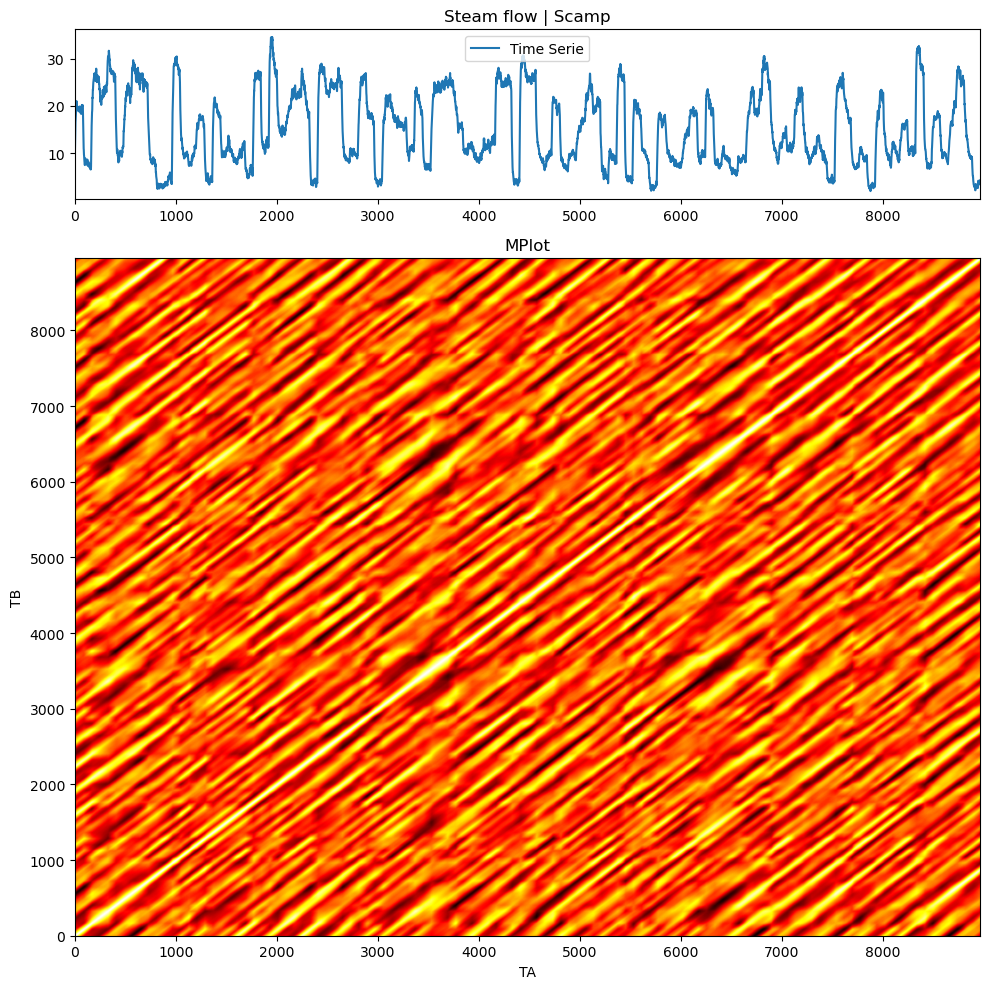

In [158]:
#| hide 
#foo = MatrixProfilePlot(data = steam_df['steam flow'], subsequence_len = 640)
foo = DistanceProfile(data = steam_df['steam flow'], subsequence_len = 640)
foo = MatrixProfilePlot(similarity_matrix = foo)
foo

#reference_idx = np.random.randint(low=0, high=len(foo_ts) - 640)
#reference_subseq = foo_ts[reference_idx:reference_idx + 640]

#foo.compute_similarity_matrix(foo.subsequence_len, None, 'stump', True, True)
#foo.similarity_matrix.shape
#foo.plot('Steam flow', 'Stumpy')
foo.compute_similarity_matrix(
    method             = 'scamp', 
    print_flag         = True, 
    debug              = False,
    timed              = True, 
    allow_experimental = False,
    ensure_symetric    = True
)
foo.plot('Steam flow', 'Scamp')

--> Stump
matrix profile 50.994271755218506 seconds -->


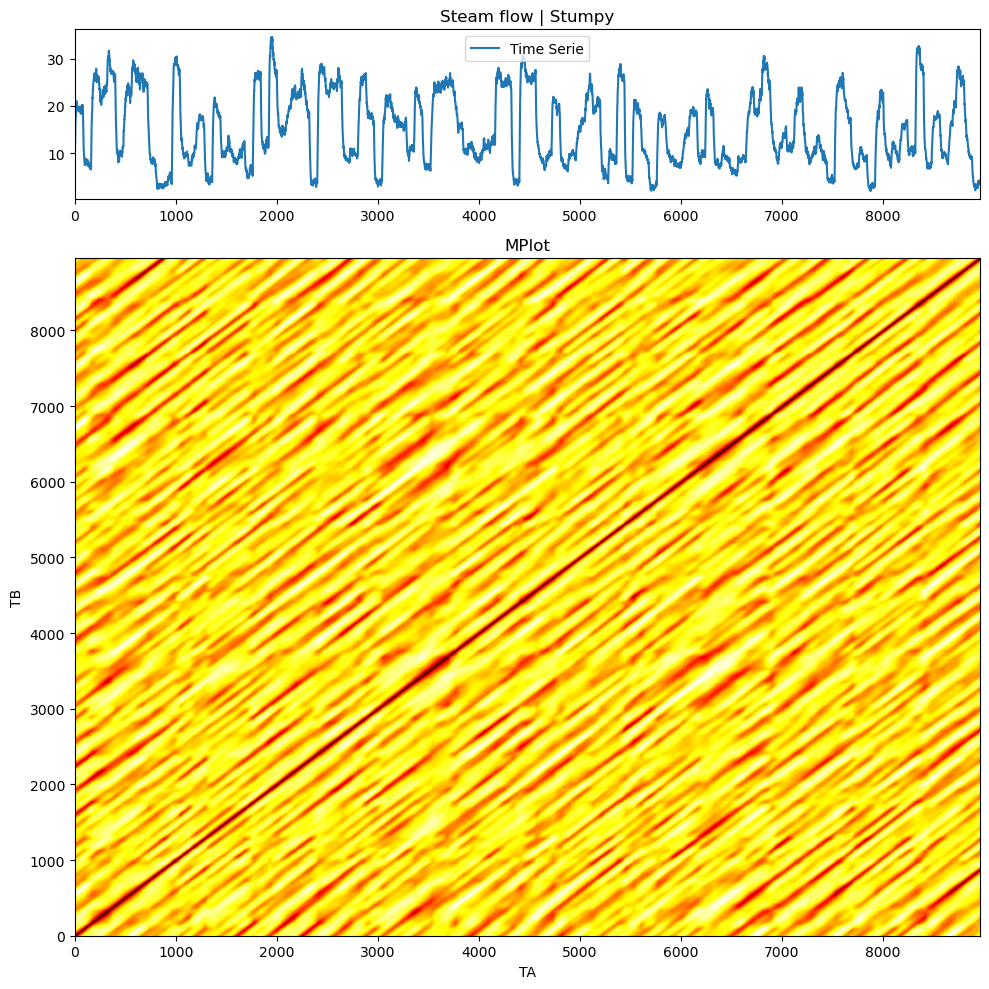

In [162]:
foo.compute_similarity_matrix(
    method             = 'stump', 
    print_flag         = True, 
    debug              = False,
    timed              = True, 
    allow_experimental = False,
    ensure_symetric    = True
)
foo.plot('Steam flow', 'Stumpy')

### SPLAT: Using cache for computing & saving plots

In [5]:
#| export
@dataclass 
class CachedPlot:
    """ Specific clase for using cached interactive plots for MPlots """
    fig              = None
    ax2              = None
    ax3              = None
    ax4              = None 
    data             = None
    data_b           = None
    subsequence_len  = None 
    matrix_dim       = None
    gs               = None
    cax              = None
    cache            = {}
    filename : str   = ""

    def get_matrix(
        self,
        a_id_start : int, 
        a_id_end : int,
        b_id_start : int, 
        b_id_end : int
    ) -> List [ float ]: 
        data   = self.data[a_id_start:a_id_end]
        data_b = self.data_b[b_id_start:b_id_end]
        
        cache_key = (a_id_start, a_id_end, b_id_start, b_id_end)
        matrix    = None
        
        if cache_key in self.cache:
            matrix = self.cache[cache_key]
        else:
            if len(data) > 1000 * self.matrix_dim and len(data_b) > 1000 * self.matrix_dim:
                # Currently GPU Matrix summaries can leave some spotty output if the input size is not large enough. So only allow GPU computation when we can be sure we will fill in the whole matrix
                # TODO Follow Zach (zpzim): Implement GPU Matrix summaries which will generate the same output as the CPU version.
                matrix = mp.abjoin(
                    data, data_b, self.subsequence_len, 
                    mwidth = self.matrix_dim, mheight = self.matrix_dim
                )
            else:
                matrix = mp.abjoin(
                    data, data_b, self.subsequence_len, 
                    mwidth = self.matrix_dim, mheight = self.matrix_dim,
                    gpus = [], pearson = True
                )
            self.cache[cache_key] = matrix
            ## Cuidado con esto. Si algún día lo metemos en MVP hay que tener cuidado
            ## Porque ya al usar MatrixProfile daba problemas por detectar el 0 como patrón
            matrix[np.isnan(matrix)] = 0
        return matrix 

    def ids_int(self, ids ):
        id1, id2 = ids
        return int(id1), int(id2) 
    def on_xlims_change(self, event_ax, print_flag = True):
        a_id_start, a_id_end = self.ids_int(event_ax.get_xlim())
        b_id_end, b_id_start = self.ids_int(self.ax3.get_ylim())
        if print_flag: print(a_id_start, a_id_end, b_id_start, b_id_end)
        self.redraw_matrix(a_id_start, a_id_end, b_id_start, b_id_end)

    def on_ylims_change(self,event_ax, print_flag = True):
        st_a, ed_a = self.ids_int(self.ax2.get_xlim())
        ed_b, st_b = self.ids_int(event_ax.get_ylim())
        
        if print_flag: print(st_a, ed_a, st_b, ed_b)
        
        self.redraw_matrix(st_a, ed_a, st_b, ed_b)

    def redraw_matrix(
        self,
        a_id_start : int, 
        a_id_end : int,
        b_id_start : int,
        b_id_end : int
    ) -> None:
        matrix = self.get_matrix(a_id_start, a_id_end, b_id_start, b_id_end)
        self.cax.remove()
        self.cax = self.ax4.mathshow(
            matrix, 
            extent = [a_id_start, a_id_end, b_id_end, b_id_start], 
            interpolation = 'none'
        )
        self.ax4.set_adjustable('box')
        self.ax4.set_aspect('auto')
        self.ax4.autoscale(False)
        self.ax4.callbacks.connect('ylim_changed', self.on_ylims_change)
        self.ax4.callbacks.connect('xlim_changed', self.on_xlims_change)

    def plot_matrix_interactive(
        self, 
        data : List [ float ], 
        data_b : List [ float ], 
        subsequence_len : int, 
        filename : str = "cached_matrix_plot.png",
        print_flag : bool = True
    ) : 
        if self.data is None : 
            self.data = np.copy(a)
        if self.data_b is None : 
            if data_b is None:
                self.data_b = self.data
            else: 
                self.data_b = np.copy(data_b)
        self.subsequence_len = subsequence_len
        self.matrix_dim = matrix_dim
        if filename is not None:
            self.filename = filename

        n_x = len(self.data) - self.subsequence_len + 1
        n_y = len(self.data_b) - self.subsequence_len + 1 
        
        ratio = len(self.data) / len(self.data_b)

        matrix_dim_a = math.floor(ratio * matrix_dim)
        matrix_dim_b = self.matrix_dim

        matrix = get_matrix(0, len (self.data), 0, len(self.data_b))
        if print_flag : print(matrix.dtype)
        
        self.fig = plt.figure(
            constrained_layout=False, 
            facecolor='0.9', 
            figsize=(32,32)
        )
        self.gs = fig.add_gridspec(
            nrows=2, 
            ncols=2,  
            hspace=0, 
            wspace=0, 
            width_ratios=[1,3], 
            height_ratios=[1,3]
        )

        self.ax2 = fig.add_subplot(self.gs[:-1,-1])
        self.ax3 = fig.add_subplot(self.gs[-1,:-1])
        self.ax4 = fig.add_subplot(
            self.gs[-1, -1], 
            sharex=self.ax2, 
            sharey=self.ax3
        )

        cax = self.ax4.matshow(
            matrix, 
            extent=[0, n_x, n_y, 0], 
            interpolation='none'
        )
        #cax = ax4.matshow(matrix, interpolation='none')
        self.ax4.set_adjustable('box')
        self.ax4.set_aspect('auto')
        self.ax4.autoscale(False)
        axins = inset_axes(
            self.ax4, 
            width='100%', 
            height='5%', 
            loc ='lower center', 
            borderpad=-5
        )
        self.fig.colorbar(
            self.cax, 
            cax=axins, 
            orientation='horizontal'
        )
        
        self.ax4.set_axis_off()
        self.ax4.axis('off')

        self.ax2.plot([i for i in range(n_x)], data[:n_x])
        self.ax2.set_xlim(xmin=0, xmax=n_x)
        self.ax2.xaxis.set_ticks_position('top')
        self.ax2.set_axisbelow(False)
        self.ax3.plot(b[:n_y], [i for i in range(n_y)])
        self.ax3.set_ylim(ymin=0, ymax=n_y)
        self.ax3.invert_yaxis()
        self.ax3.invert_xaxis()
        ### Callbacks
        self.ax2.callbacks.connect('xlim_changed', on_xlims_change)
        self.ax3.callbacks.connect('ylim_changed', on_ylims_change)
        self.ax4.callbacks.connect('ylim_changed', on_xlims_change)
        self.ax4.callbacks.connect('xlim_changed', on_ylims_change)
        plt.show()
        if self.filename is not None:
            self.fig.savefig(filename, bbox_inches='tight')
    return self.fig
    
    def plot_matrix(self, matrix, arr, n, scale_factor, outfile):
        #Auxiliar, para testear, por eso no son las globales (entiendo)
        plt.tight_layout()
        fig = plt.figure(constrained_layout=False, facecolor='0.9', figsize=(32,32))
        gs = fig.add_gridspec(nrows=2, ncols=2,  hspace=0, wspace=0, width_ratios=[1,3], height_ratios=[1,3])

        ax2 = fig.add_subplot(gs[:-1,-1])
        ax3 = fig.add_subplot(gs[-1,:-1])
        ax4 = fig.add_subplot(gs[-1, -1])

        ax4.matshow(matrix)

        ax4.set_axis_off()
        ax4.axis('off')

        ax2.plot([i for i in range(n)], arr[:n])
        ax2.set_xlim(xmin=0, xmax=n)
        ax2.xaxis.set_ticks_position('top')
        ax2.set_axisbelow(False)
        ax3.plot(arr[:n], [i for i in range(n)])
        ax3.set_ylim(ymin=0, ymax=n)
        ax3.invert_yaxis()
        ax3.invert_xaxis()
        fig.savefig(outfile, bbox_inches='tight')
        plt.close(fig)


    
            

In [7]:
#| hide
foo = CachedPlot()
foo.ids_int((0.0, 1.0))

(0, 1)

In [ ]:
#| export
@dataclass
class MatrixProfilePlotCached:
    """ Time series similarity matrix plot using cache """
    
    similarity_matrix : DistanceProfile = None
    
    def compute_similarity_matrix(
        self,
        method = 'scamp',
        print_flag : bool = False,
        debug : bool = False, 
        timed : bool = True, 
        allow_experimental : bool = True,
        ensure_symetric : bool = True
    ) -> List [ List [ float ] ] :
        self.similarity_matrix.compute(
            method = method,
            print_flag = print_flag,
            debug = debug,
            timed = timed, 
            allow_experimental = allow_experimental,
            ensure_symetric = ensure_symetric
        )
            
            
    def plot(self, ts_name, method = 'Scamp'):
        fig = plt.figure(figsize=(10, 10))
        gs = GridSpec(2, 1, height_ratios=[1, 4])

        # Serie temporal
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(self.similarity_matrix.data, label="Time Serie")
        ax1.set_title(ts_name + " | " +  method)
        ax1.legend()

        # MPlot
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        # Utilizar 'imshow' para visualizar la matriz MPlot
        ax2.imshow(self.similarity_matrix.similarity_matrix, 
                   aspect='auto', origin='lower', cmap='hot', 
                   extent=(0, len(self.similarity_matrix.data) - self.similarity_matrix.subsequence_len, 
                           0, len(self.similarity_matrix.data) - self.similarity_matrix.subsequence_len)
                  )
        ax2.set_title("MPlot")
        ax2.set_xlabel('TA')
        ax2.set_ylabel('TB')

        plt.tight_layout()
        plt.show()

## Global variables

In [163]:
#| export
eamonn_drive_mplots = {
    'insects0': {
        'id': '1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ',
        'name': 'InsectData-fig11'
    }
}

In [166]:
#| hide 
eamonn_drive_mplots['insects0']['name']

'InsectData-fig11'